In [1]:
!pip install xgboost -U

In [2]:
!pip install lightgbm

In [3]:
pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install torch

In [5]:
!pip install geopy

In [6]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

import xgboost as xgb
import lightgbm as lgb
import torch

from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', 100)

In [7]:
DEBUG = False

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [9]:
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))
 
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL); 

In [10]:
DATA_DIR = r"C:\Users\admin\Desktop\Data Sources\Enefit - Predict Energy Behavior of Prosumers"

energy = pd.read_csv(DATA_DIR + r"\energy.csv")
client = pd.read_csv(DATA_DIR + r"\client.csv")
hist_weather = pd.read_csv(DATA_DIR + r"\historical_weather.csv")
fore_weather = pd.read_csv(DATA_DIR + r"\forecast_weather.csv")
electr = pd.read_csv(DATA_DIR + r"\electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + r"\gas_prices.csv")

In [11]:
location = (pd.read_csv(r"C:\Users\admin\Desktop\Data Sources\fabiendaniels-mapping-locations-and-county-codes\county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [12]:
energy = energy.rename(columns={'target': 'energy'})
display_df(energy, 'energy')
display_df(client, 'client')
display_df(hist_weather, 'historical weather')
display_df(fore_weather, 'forecast weather')
display_df(electr, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

energy data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,energy,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical weather data has 1710802 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


forecast weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas prices data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data data has 75 rows and 3 columns. 
 ===> First row:


,county,longitude,latitude
0,0,24.2,59.1


In [13]:
datablockid0_ene = energy.loc[energy['data_block_id'] == 1]
datablockid0_cli = client.loc[client['data_block_id'] == 0]
datablockid0_his = hist_weather.loc[hist_weather['data_block_id'] == 0]
datablockid0_for = fore_weather.loc[fore_weather['data_block_id'] == 0]
datablockid0_ele = electr.loc[electr['data_block_id'] == 1]
datablockid0_gas = gas.loc[gas['data_block_id'] == 0]
datablockid0_ele

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
5,2021-09-01 05:00:00,93.58,2021-08-31 05:00:00,1
6,2021-09-01 06:00:00,118.70,2021-08-31 06:00:00,1
7,2021-09-01 07:00:00,135.44,2021-08-31 07:00:00,1
8,2021-09-01 08:00:00,140.72,2021-08-31 08:00:00,1
9,2021-09-01 09:00:00,130.00,2021-08-31 09:00:00,1


In [14]:
# See county codes
with open(DATA_DIR + r'/county_id_to_name_map.json') as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


In [15]:
import datetime

class Processor():
    def __init__(self):
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electr_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        self.lat_lon_columns = ['latitude', 'longitude']
        
        self.agg_stats = ['mean']
        
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        df.columns = [col + suffix if col not in columns_no_change else col for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def process_date(self, base):

        base['datetime'] = pd.to_datetime(base['datetime'])
         
        base['date'] = base['datetime'].dt.normalize()
        base['year'] = base['datetime'].dt.year
        base['quarter'] = base['datetime'].dt.quarter
        base['month'] = base['datetime'].dt.month
        base['week'] = base['datetime'].dt.isocalendar().week
        base['hour'] = base['datetime'].dt.hour
        
        base['day_of_year'] = base['datetime'].dt.day_of_year
        base['day_of_month']  = base['datetime'].dt.day
        base['day_of_week'] = base['datetime'].dt.day_of_week
        return base

    def process_client(self, client):
        client = self.create_new_column_names(client, suffix='_client', columns_no_change = self.client_join)       
        return client
    
    def process_hist_weather(self, hist_weather):
        hist_weather['datetime'] = pd.to_datetime(hist_weather['datetime'])

        hist_weather[self.lat_lon_columns] = hist_weather[self.lat_lon_columns].astype(float).round(1)
        hist_weather = hist_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        hist_weather = self.create_new_column_names(hist_weather, suffix='_h', columns_no_change = self.lat_lon_columns + self.weather_join) 
        
        agg_columns = [col for col in hist_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        hist_weather = hist_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 

        hist_weather = self.flatten_multi_index_columns(hist_weather) 

        hist_weather['hour_h'] = hist_weather['datetime'].dt.hour
        hist_weather['datetime'] = (hist_weather.apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return hist_weather
    
    def process_fore_weather(self, fore_weather):
        fore_weather = (fore_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime')
                           )
        
        fore_weather['datetime'] = (pd.to_datetime(fore_weather['datetime']).dt.tz_localize(None))

        fore_weather[self.lat_lon_columns] = fore_weather[self.lat_lon_columns].astype(float).round(1)
        fore_weather = fore_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        fore_weather = self.create_new_column_names(fore_weather, suffix='_f', columns_no_change = self.lat_lon_columns + self.weather_join) 
        
        agg_columns = [col for col in fore_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        fore_weather = fore_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        fore_weather = self.flatten_multi_index_columns(fore_weather)     
        return fore_weather

    def process_electr(self, electr):
        electr['forecast_date'] = pd.to_datetime(electr['forecast_date'])
        electr['datetime'] = electr['forecast_date'] + pd.DateOffset(1)
        electr = self.create_new_column_names(electr, suffix='_electr', columns_no_change = self.electr_join)             
        return electr

    def process_gas(self, gas):
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        gas = self.create_new_column_names(gas, suffix='_gas', columns_no_change = self.gas_join)       
        return gas
    
    def __call__(self, base, client, hist_weather, fore_weather, electr, gas):
        base = self.process_date(base)
        client = self.process_client(client)
        hist_weather = self.process_hist_weather(hist_weather)
        fore_weather = self.process_fore_weather(fore_weather)
        electr = self.process_electr(electr)
        gas = self.process_gas(gas)
        
        df = base.merge(client, how='left', on = self.client_join)
        df = df.merge(hist_weather, how='left', on = self.weather_join)
        df = df.merge(fore_weather, how='left', on = self.weather_join)
        df = df.merge(electr, how='left', on = self.electr_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [16]:
processor = Processor()
base = processor(base=energy.copy(),
                 client=client.copy(),
                 hist_weather=hist_weather.copy(),
                 fore_weather=fore_weather.copy(),
                 electr=electr.copy(),
                 gas=gas.copy()
                )
base_cleaned = base.dropna(subset=['forecast_date_electr', 'euros_per_mwh_electr'])
condition_to_drop = base_cleaned['product_type'] != 3
indices_to_drop = base_cleaned[condition_to_drop].index
base_cleaned.drop(indices_to_drop, inplace=True)
base_cleaned.reset_index(drop=True)

base_cleaned['energy_pro'] = float('nan')
base_cleaned['energy_con'] = float('nan')

base_cleaned.loc[base_cleaned['is_consumption'] == 0, 'energy_pro'] = base_cleaned.loc[base_cleaned['is_consumption'] == 0, 'energy']
base_cleaned.loc[base_cleaned['is_consumption'] == 1, 'energy_con'] = base_cleaned.loc[base_cleaned['is_consumption'] == 1, 'energy']

base_cleaned = base_cleaned.groupby(['prediction_unit_id', 'datetime']).first().reset_index()

base_cleaned.drop(columns=['is_consumption', 'energy'], inplace=True)
base_cleaned.insert(4, 'energy_pro', base_cleaned.pop('energy_pro'))
base_cleaned.insert(5, 'energy_con', base_cleaned.pop('energy_con'))

base_cleaned

C:\Users\admin\AppData\Local\Temp\ipykernel_15940\3308079938.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cleaned.drop(indices_to_drop, inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_15940\3308079938.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cleaned['energy_pro'] = float('nan')
C:\Users\admin\AppData\Local\Temp\ipykernel_15940\3308079938.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,prediction_unit_id,datetime,county,is_business,energy_pro,energy_con,product_type,data_block_id,row_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electr,euros_per_mwh_electr,origin_date_electr,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas
0,2,2021-09-02 00:00:00,0,0,1.003,735.696,3,1,2932,2021-09-02,2021,3,9,35,0,245,2,3,NaN,NaN,None,13.79,10.73,0.00,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,0.0,22.0,11.456836,6.023010,0.000000,0.153970,0.097862,0.195584,1.835148,-6.649460,0.000000,0.000000,0.0,2.880096e-05,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
1,2,2021-09-02 01:00:00,0,0,0.626,672.163,3,1,3054,2021-09-02,2021,3,9,35,1,245,2,3,NaN,NaN,None,13.62,10.35,0.00,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,1.0,23.0,11.223425,5.769751,0.000000,0.130124,0.046486,0.145770,1.853999,-6.731090,0.000000,0.000000,0.0,1.602173e-05,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
2,2,2021-09-02 02:00:00,0,0,0.548,687.776,3,1,3176,2021-09-02,2021,3,9,35,2,245,2,3,NaN,NaN,None,13.13,10.07,0.00,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,2.0,24.0,11.009802,5.639551,0.000000,0.071155,0.022380,0.079021,2.202772,-6.663764,0.000000,0.000000,0.0,7.355213e-06,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
3,2,2021-09-02 03:00:00,0,0,0.252,689.527,3,1,3298,2021-09-02,2021,3,9,35,3,245,2,3,NaN,NaN,None,12.74,9.94,0.00,0.0,1010.09,8.6,6.5,0.9,7.5,4.944444,335.5,0.0,0.0,0.0,3.0,25.0,10.760083,5.577930,0.000000,0.028575,0.009357,0.033420,2.637797,-6.521071,0.000000,0.000000,0.0,1.716614e-06,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
4,2,2021-09-02 04:00:00,0,0,0.167,702.627,3,1,3420,2021-09-02,2021,3,9,35,4,245,2,3,NaN,NaN,None,12.46,10.03,0.00,0.0,1009.83,4.1,2.8,0.6,4.2,4.669444,330.6,0.0,0.0,0.0,4.0,26.0,10.519543,5.593103,0.000000,0.003389,0.000264,0.003528,2.906404,-6.406646,0.000000,-0.036000,0.0,2.026558e-07,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458575,60,2023-05-31 19:00:00,15,1,111.403,171.252,3,637,2017830,2023-05-31,2023,2,5,22,19,151,31,2,55.0,2188.2,2023-05-29,15.44,6.70,0.16,0.0,1003.74,40.2,10.2,52.0,0.0,2.255556,331.6,132.8,63.8,69.0,19.0,41.0,17.325195,6.261377,0.281747,0.010187,0.638226,0.732465,5.229700,-1.262375,89.023111,114.271111,0.0,0.000000e+00,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,2023-05-30,29.00,34.00,2023-05-29,31.500
458576,60,2023-05-31 20:00:00,15,1,43.751,232.759,3,637,2017960,2023-05-31,2023,2,5,22,20,151,31,2,55.0,2188.2,2023-05-29,14.44,7.48,0.04,0.0,1003.70,27.8,10.2,31.4,0.2,1.666667,268.2,60.8,20.8,40.0,20.0,42.0,15.589502,7.034863,0.016388,0.006775,0.252264,0.264978,4.658811,-1.008493,164.384889,75.212444,0.0,0.000000e+00,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,2023-05-30,29.00,34.00,2023-05-29,31.500
458577,60,2023-05-31 21:00:00,15,1,

In [17]:
n = 5
for i in range(1, n+2):
    base_cleaned[f'prev_day_{i}_euros_per_mwh_electr'] = base_cleaned.groupby('prediction_unit_id')['euros_per_mwh_electr'].shift(i)

df = base_cleaned

In [18]:
base_cleaned

,prediction_unit_id,datetime,county,is_business,energy_pro,energy_con,product_type,data_block_id,row_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electr,euros_per_mwh_electr,origin_date_electr,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,prev_day_1_euros_per_mwh_electr,prev_day_2_euros_per_mwh_electr,prev_day_3_euros_per_mwh_electr,prev_day_4_euros_per_mwh_electr,prev_day_5_euros_per_mwh_electr,prev_day_6_euros_per_mwh_electr
0,2,2021-09-02 00:00:00,0,0,1.003,735.696,3,1,2932,2021-09-02,2021,3,9,35,0,245,2,3,NaN,NaN,None,13.79,10.73,0.00,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,0.0,22.0,11.456836,6.023010,0.000000,0.153970,0.097862,0.195584,1.835148,-6.649460,0.000000,0.000000,0.0,2.880096e-05,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2021-09-02 01:00:00,0,0,0.626,672.163,3,1,3054,2021-09-02,2021,3,9,35,1,245,2,3,NaN,NaN,None,13.62,10.35,0.00,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,1.0,23.0,11.223425,5.769751,0.000000,0.130124,0.046486,0.145770,1.853999,-6.731090,0.000000,0.000000,0.0,1.602173e-05,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775,92.51,NaN,NaN,NaN,NaN,NaN
2,2,2021-09-02 02:00:00,0,0,0.548,687.776,3,1,3176,2021-09-02,2021,3,9,35,2,245,2,3,NaN,NaN,None,13.13,10.07,0.00,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,2.0,24.0,11.009802,5.639551,0.000000,0.071155,0.022380,0.079021,2.202772,-6.663764,0.000000,0.000000,0.0,7.355213e-06,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775,88.90,92.51,NaN,NaN,NaN,NaN
3,2,2021-09-02 03:00:00,0,0,0.252,689.527,3,1,3298,2021-09-02,2021,3,9,35,3,245,2,3,NaN,NaN,None,12.74,9.94,0.00,0.0,1010.09,8.6,6.5,0.9,7.5,4.944444,335.5,0.0,0.0,0.0,3.0,25.0,10.760083,5.577930,0.000000,0.028575,0.009357,0.033420,2.637797,-6.521071,0.000000,0.000000,0.0,1.716614e-06,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775,87.35,88.90,92.51,NaN,NaN,NaN
4,2,2021-09-02 04:00:00,0,0,0.167,702.627,3,1,3420,2021-09-02,2021,3,9,35,4,245,2,3,NaN,NaN,None,12.46,10.03,0.00,0.0,1009.83,4.1,2.8,0.6,4.2,4.669444,330.6,0.0,0.0,0.0,4.0,26.0,10.519543,5.593103,0.000000,0.003389,0.000264,0.003528,2.906404,-6.406646,0.000000,-0.036000,0.0,2.026558e-07,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775,86.88,87.35,88.90,92.51,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458575,60,2023-05-31 19:00:00,15,1,111.403,171.252,3,637,2017830,2023-05-31,2023,2,5,22,19,151,31,2,55.0,2188.2,2023-05-29,15.44,6.70,0.16,0.0,1003.74,40.2,10.2,52.0,0.0,2.255556,331.6,132.8,63.8,69.0,19.0,41.0,17.325195,6.261377,0.281747,0.010187,0.638226,0.732465,5.229700,-1.262375,89.023111,114.271111,0.0,0.000000e+00,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,2023-05-30,29.00,34.00,2023-05-29,31.500,82.10,9.55,11.92,13.10,19.63,57.36
458576,60,2023-05-31 20:00:00,15,1,43.751,232.759,3,6

In [19]:
train_block_id = list(range(0, 500)) 

tr = df[df['data_block_id'].isin(train_block_id)] # first 600 data_block_ids used for training
val = df[~df['data_block_id'].isin(train_block_id)] # rest data_block_ids used for validation

no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append('euros_per_mwh_electr')
features = [col for col in df.columns if col not in remove_columns]
PrintColor(f'There are {len(features)} features: {features}')

There are 51 features: ['prediction_unit_id', 'county', 'is_business', 'energy_pro', 'energy_con', 'product_type', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'lowest_price_per_mwh_gas', 'highest_price_per_mwh_gas',

In [20]:
clf = xgb.XGBRegressor(
                        objective = 'reg:absoluteerror',
                        device = device,
                        enable_categorical=True,
                        n_estimators = 2 if DEBUG else 1500,
                        early_stopping_rounds=100,
                       )
# negative values: objective='reg:squarederror'

In [21]:
clf.fit(X = tr[features], 
        y = tr['euros_per_mwh_electr'], 
        eval_set = [(tr[features], tr['euros_per_mwh_electr']), (val[features], val['euros_per_mwh_electr'])], 
        verbose=True #False #True
       )

[0]	validation_0-mae:68.20056	validation_1-mae:51.57184
[1]	validation_0-mae:55.11131	validation_1-mae:40.76195
[2]	validation_0-mae:46.02787	validation_1-mae:33.85164
[3]	validation_0-mae:39.11957	validation_1-mae:26.56749
[4]	validation_0-mae:34.35881	validation_1-mae:21.96335
[5]	validation_0-mae:30.72630	validation_1-mae:17.83952
[6]	validation_0-mae:28.20409	validation_1-mae:16.00132
[7]	validation_0-mae:26.56058	validation_1-mae:14.67977
[8]	validation_0-mae:25.38598	validation_1-mae:14.00929
[9]	validation_0-mae:24.55263	validation_1-mae:13.52472
[10]	validation_0-mae:23.92982	validation_1-mae:13.22450
[11]	validation_0-mae:23.59085	validation_1-mae:13.03708
[12]	validation_0-mae:23.24508	validation_1-mae:12.86554
[13]	validation_0-mae:23.00157	validation_1-mae:12.83771
[14]	validation_0-mae:22.78286	validation_1-mae:12.78830
[15]	validation_0-mae:22.67604	validation_1-mae:12.76231
[16]	validation_0-mae:22.57996	validation_1-mae:12.71890
[17]	validation_0-mae:22.51298	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
PrintColor(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')

Early stopping on best iteration #25 with MAE error on validation set of 12.54


In [23]:
PrintColor(f'The maximum value of euros_per_mwh_electr is {df['euros_per_mwh_electr'].max()}, and the minimum value of euros_per_mwh_electr is {df['euros_per_mwh_electr'].min()}')

The maximum value of euros_per_mwh_electr is 4000.0, and the minimum value of euros_per_mwh_electr is -10.06


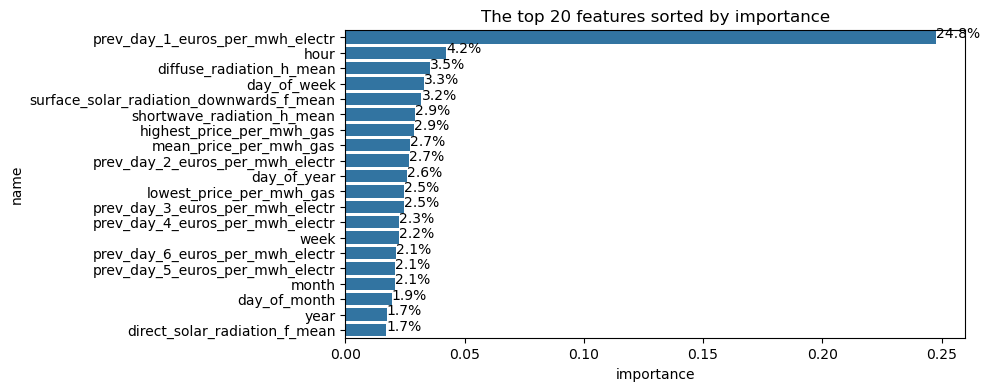

In [24]:
TOP = 20
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [25]:
y_pred = clf.predict(tr[features])
y_true = tr['euros_per_mwh_electr']
compare = pd.DataFrame({'true': y_true, 'predicted': y_pred})
dfcompare = pd.concat([tr[features], compare], axis=1)
dfcompare.head()

,prediction_unit_id,county,is_business,energy_pro,energy_con,product_type,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,mean_price_per_mwh_gas,prev_day_1_euros_per_mwh_electr,prev_day_2_euros_per_mwh_electr,prev_day_3_euros_per_mwh_electr,prev_day_4_euros_per_mwh_electr,prev_day_5_euros_per_mwh_electr,prev_day_6_euros_per_mwh_electr,true,predicted
0,2,0,0,1.003,735.696,3,2021,3,9,35,0,245,2,3,NaN,NaN,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,11.456836,6.023010,0.0,0.153970,0.097862,0.195584,1.835148,-6.649460,0.0,0.000,0.0,2.880096e-05,45.23,46.32,45.775,NaN,NaN,NaN,NaN,NaN,NaN,92.51,92.736664
1,2,0,0,0.626,672.163,3,2021,3,9,35,1,245,2,3,NaN,NaN,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,11.223425,5.769751,0.0,0.130124,0.046486,0.145770,1.853999,-6.731090,0.0,0.000,0.0,1.602173e-05,45.23,46.32,45.775,92.51,NaN,NaN,NaN,NaN,NaN,88.90,88.782188
2,2,0,0,0.548,687.776,3,2021,3,9,35,2,245,2,3,NaN,NaN,13.13,10.07,0.0,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,11.009802,5.639551,0.0,0.071155,0.022380,0.079021,2.202772,-6.663764,0.0,0.000,0.0,7.355213e-06,45.23,46.32,45.775,88.90,92.51,NaN,NaN,NaN,NaN,87.35,88.452011
3,2,0,0,0.252,689.527,3,2021,3,9,35,3,245,2,3,NaN,NaN,12.74,9.94,0.0,0.0,1010.09,8.6,6.5,0.9,7.5,4.944444,335.5,0.0,0.0,0.0,10.760083,5.577930,0.0,0.028575,0.009357,0.033420,2.637797,-6.521071,0.0,0.000,0.0,1.716614e-06,45.23,46.32,45.775,87.35,88.90,92.51,NaN,NaN,NaN,86.88,85.946373
4,2,0,0,0.167,702.627,3,2021,3,9,35,4,245,2,3,NaN,NaN,12.46,10.03,0.0,0.0,1009.83,4.1,2.8,0.6,4.2,4.669444,330.6,0.0,0.0,0.0,10.519543,5.593103,0.0,0.003389,0.000264,0.003528,2.906404,-6.406646,0.0,-0.036,0.0,2.026558e-07,45.23,46.32,45.775,86.88,87.35,88.90,92.51,NaN,NaN,88.43,88.859711


In [26]:
PrintColor(f'The maximum value of euros_per_mwh_electr is {dfcompare['true'].max()}, and the minimum value of euros_per_mwh_electr is {dfcompare['true'].min()}')

The maximum value of euros_per_mwh_electr is 4000.0, and the minimum value of euros_per_mwh_electr is -0.04
